In [39]:
%matplotlib inline
import re
from collections import Counter
from pathlib import Path
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.fftpack import fft
import pandas as pd
from scipy.io import wavfile
import IPython.display as IPD
from sklearn.model_selection import KFold
import librosa
import experiment
import augment
import config
import utils
import submit

utils.set_seed(2017)

In [40]:
# from https://www.kaggle.com/davids1992/speech-visualization-and-exploration
def log_specgram(audio, sample_rate=config.SAMPLE_RATE, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [41]:
def speech_visualize(samples, sample_rate, wfname):
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    xf, vals = custom_fft(samples, sample_rate)

    fig = plt.figure(figsize=(14, 16))
    ax1 = fig.add_subplot(311)
    ax1.set_title('Raw wave of ' + wfname)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

    ax2 = fig.add_subplot(312)
    ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax2.set_yticks(freqs[::16])
    ax2.set_xticks(times[::16])
    ax2.set_title('Spectrogram of ' + wfname)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')

    ax3 = fig.add_subplot(313)
    ax3.set_title('FFT of ' + wfname)
    ax3.set_xlabel('Frequency')
    ax3.grid()
    ax3.plot(xf, vals)

In [44]:
train_paths, bgn_paths, _ = experiment.data_load("2017_12_08_15_41_26")
test_paths, _ = submit.test_data_load()
print("white_noise" in bgn_paths.path)

False


In [6]:
bgn_paths = bgn_paths[~bgn_paths.path.str.contains("white")]

In [7]:
bgn_data = np.concatenate([librosa.core.load(x)[0] for x in bgn_paths.path])

In [128]:
fname = test_paths.path.sample().values[0]
print(fname)

input/test/audio/clip_b7532f973.wav


In [129]:
wav, _ = librosa.core.load(fname, sr=config.SAMPLE_RATE)
print(len(wav))

16000


In [130]:
IPD.Audio(wav, rate=config.SAMPLE_RATE)

In [50]:
aug_funcs = augment.Augment(bgn_data, config.AUG_LIST)

In [51]:
def speech_visualize(samples, sample_rate, wfname):
    freqs, times, spectrogram = log_specgram(samples, sample_rate)
    xf, vals = custom_fft(samples, sample_rate)

    fig = plt.figure(figsize=(14, 16))
    ax1 = fig.add_subplot(311)
    ax1.set_title('Raw wave of ' + wfname)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

    ax2 = fig.add_subplot(312)
    ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax2.set_yticks(freqs[::16])
    ax2.set_xticks(times[::16])
    ax2.set_title('Spectrogram of ' + wfname)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')

    ax3 = fig.add_subplot(313)
    ax3.set_title('FFT of ' + wfname)
    ax3.set_xlabel('Frequency')
    ax3.grid()
    ax3.plot(xf, vals)

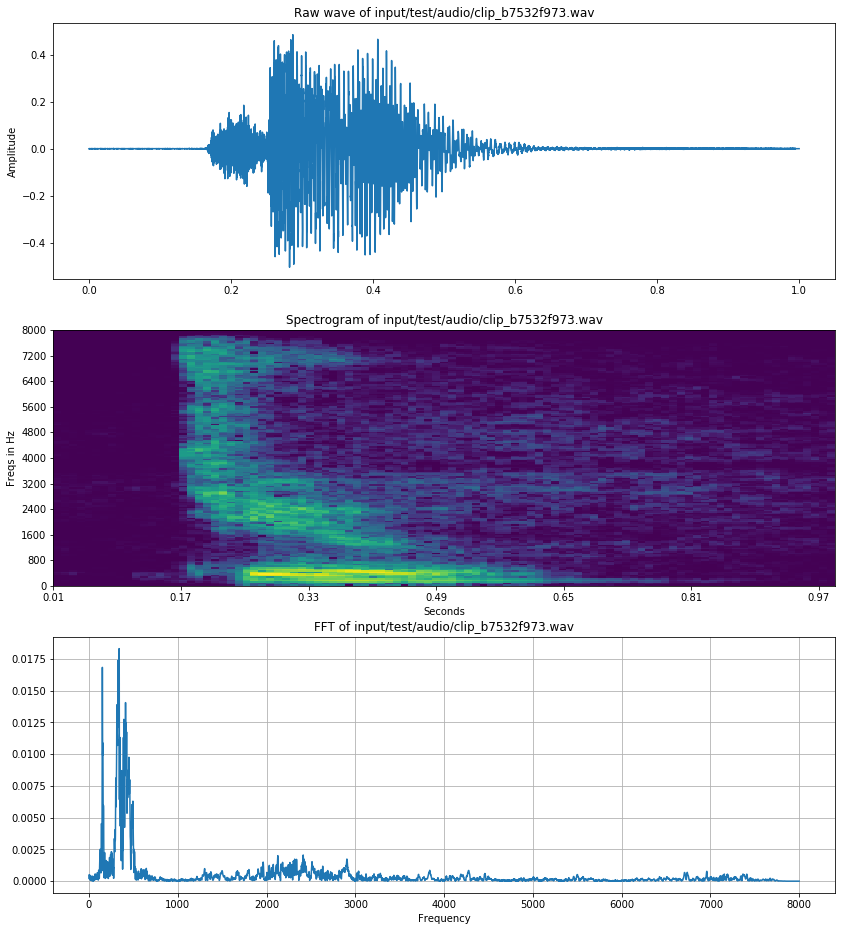

In [133]:
# wav_wn = aug_funcs.abbrev_func_map["mix_bgn"](wav)
# wav_pitchup = augment.mix_bgn_wav(wav, bgn_data, mix_rate=0.5)
wav_pitchup = aug_funcs.abbrev_func_map["vol_up"](wav)
# wav_pitchup = augment.strech(wav, rate=0.8)
speech_visualize(wav_pitchup, config.SAMPLE_RATE, str(fname))

In [134]:
IPD.Audio(wav_pitchup, rate=config.SAMPLE_RATE)

In [53]:
len(bgn_data)

8806731

In [79]:
config.MIX_BGN_MAX

0.2